In [1]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
# top_path = '..'
# if top_path not in sys.path:
#     sys.path.append(top_path)

coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')
from scipy.optimize import curve_fit
# %matplotlib notebook 
# %matplotlib notebook 

In [3]:
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import sum_neg_pos_eta, read_data
from helpers import rebin_hist, add_flavors

In [380]:
use_corrections = 'T' ### Which corrections to use for deriving the uncertainties 'T' for ttbar, 'J' for QCD
### If to include unmatched in calculating the uncertainties with seperate fits and
### include them in the flavor fraction plots.
### If False, unmatched are ignored
include_unmatched = False

fine_etabins = False    ### If True use JERC default binning, if False, use the Run 1 binning (binning in HCal sectors)
one_bin      = False    ### If True, combine all the eta bins in one bin

In [381]:
color_scheme = {key: cycler_vals
    for cycler_vals, key in zip(plt.rcParams['axes.prop_cycle'], ['g', 'q', 'c', 'b', 'QCD', 'DY', 'TTBAR', 'DY200', 'unmatched'])}

leggend_dict = {'g': 'Gluons', 'q': 'Quarks', 'b': 'Bottom', 'c': 'Charm', 'unmatched': 'Unmatched'}
leggend_dict_short = {'g': 'g', 'q': 'uds', 'b': 'b', 'c': 'c', 'unmatched': 'unmatched'}

In [382]:
color_scheme

{'g': {'color': '#920000', 'marker': 'o'},
 'q': {'color': '#006ddb', 'marker': 's'},
 'c': {'color': '#24ff24', 'marker': 'p'},
 'b': {'color': '#db6d00', 'marker': 'd'},
 'QCD': {'color': '#004949', 'marker': 'D'},
 'DY': {'color': '#b66dff', 'marker': 'H'},
 'TTBAR': {'color': '#b6dbff', 'marker': '^'},
 'DY200': {'color': '#924900', 'marker': 'o'},
 'unmatched': {'color': '#ffff6d', 'marker': 's'}}

In [383]:
color_scheme['unmatched'] = {'color': '#e5e562', 'marker': 's'}

In [384]:
# plt.rcParams['figure.dpi']=200

In [385]:
def get_output(data_tag):
    ''' Load response histogram data with the tag `data_tag`
    '''
    tag_full = '_L5'+data_tag
    outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
    output = util.load(outname)
    return output

In [386]:
def get_file_dict(data_tag):
    ''' Load a text file with cross sections and file names as a dictionary `file_dict`.
    '''
    if "_QCD-MG" in data_tag:
        if data_tag=='_DY-MG-Her':
            dataset_list_file = 'fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'
        else:
            dataset_list_file = 'fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt'
        with open(dataset_list_file) as f:
            lines = f.readlines()
        lines_split = [line.split() for line in lines]
        file_dict = {data_tag[1:]+'_'+lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    else:
        file_dict = 1
    return file_dict

In [387]:
# output_orig = output
def sum_output(output, data_tag, file_dict):
    ''' If the file with histograms `output` contains a dictionary over many datasets (e.g. different pt ranges),
    sum them up proportionally to the cross sections in `file_dict` 
    Output: summed up hisograms `output`
    '''
    if "_QCD-MG" in data_tag:
        response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
        scale_factors = hist_div(file_dict, response_sums)
        all_histo_keys = output[next(iter(output.keys()))].keys()
        result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
        output = result
    elif len(output.keys())==1:
        output = output[list(output.keys())[0]]
    return output

In [388]:
from common_binning import JERC_Constants

In [389]:
data_tag = '_Pythia-TTBAR' ##an exmaple file, used only to get the etabins
output = get_output(data_tag)
file_dict = get_file_dict(data_tag)
output = sum_output(output, data_tag, file_dict)
fineetastr = '_fineeta' if fine_etabins else ''

## find the first response histogram to extract the axes
for key in output.keys():
    if 'response' in key:
        response_key = key
        break

ptbins = output[response_key].axes["pt_gen"].edges 
ptbins_c = output[response_key].axes['pt_gen'].centers
etabins = output[response_key].axes["jeteta"].edges
if one_bin==True:
#     ptbins = np.array([ptbins[0], ptbins[-1]])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([etabins[0], 0, etabins[-1]])
elif not fine_etabins:
    etabins = np.array(JERC_Constants.etaBinsEdges_Aut18_full())
    etabins = np.array(JERC_Constants.etaBinsEdges_Win14_full())
    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_abs = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_abs[:-1]+etabins_abs[1:])/2 #output['ptresponse'].axis('jeteta').centers()
etabins_c[0] = etabins_abs[0]
etabins_c[-1] = etabins_abs[-1]-0.001

### Sum together all the different flavors

In [390]:
def combine_flavors(output, sumeta=True, include_unmatched=True):
    flavors = (['g', 'c', 'b', 'q', 'unmatched', 'all_unmatched'] if include_unmatched==True
               else ['g', 'c', 'b', 'q', 'all'])
    hists = {}
    for flav in flavors:
        combined = add_flavors(output, flavor=flav, combine_antiflavour=True )[0]
        if sumeta:
            combined = combined[:,sum,sum]
        else:
            combined = combined[:,sum,:]
        flav2 = flav if not flav=='all_unmatched' else 'all'
        hists[flav2] = combined
    return hists
 

In [391]:
from scipy.optimize import curve_fit

def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

def fit_Efractions(qfracs):
    fit_res = []
    for etaidx in range(len(qfracs[0])):
        qfrac = qfracs[:,etaidx]
        valid_fit_val = ~(np.isnan(qfrac) | np.isinf(qfrac) | (qfrac==0))
        ptbins_c_plot = ptbins_c[valid_fit_val]

        if not 'unmatched' in flav:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1]) #, sigma=np.sqrt(qfrac_var2[flav])[valid_fit_val])
        else:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1])

        if len(fit_res)==0:
            fit_res = p
        else:
            fit_res = np.vstack([fit_res, p])

    return fit_res

# fit_Efractions(qfracs2['q'])

In [392]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

def get_spline(yval):
    valid_fit_val = ~(np.isnan(yval) | np.isinf(yval) | (yval==0))
    ptbins_c_plot = ptbins_c[valid_fit_val]
    yval = yval[valid_fit_val]

    spline_func = CubicSpline(np.log10(ptbins_c_plot), yval, bc_type='natural', extrapolate=False )
    return spline_func

In [393]:
import os
def plot_Efractions(sampledict, etaidx, saveplot=False):
    samples = list(sampledict.keys())

#     ### Check that Herwig is the first sample and Pythia the second
#     if not ('Her' in samples[0] and 'Py' in samples[1]):
#         raise ValueError('key in the dictionary happened to get reversed')
    
    
    qfracs0, qfrac_var0, spline0, spline2D0 = sampledict[samples[0]]
    qfracs1, qfrac_var1, spline1, spline2D1 = sampledict[samples[1]]
    
    plot_range = range(0, np.searchsorted(ptbins_c,1250)) if 'DY' in "".join(samples) else range(0, np.searchsorted(ptbins_c,2750))
    ptbins_c_plot = ptbins_c[plot_range]
    
    fig, ax = plt.subplots()
    xplot = np.geomspace(ptbins_c_plot.min() - (1), ptbins_c_plot.max(),1000)
    xplot2 = np.geomspace(ptbins_c_plot.min(), ptbins_c_plot.max(),1000)
    points_ls = []
    for flav in qfracs0.keys():
        lab = leggend_dict_short[flav]
#         mc = next(ax._get_lines.prop_cycler)

        points = ax.errorbar(ptbins_c_plot, qfracs0[flav][plot_range, etaidx],
                             yerr=np.sqrt(qfrac_var0[flav][plot_range, etaidx]),
                             linestyle='none', label=lab,  **color_scheme[flav], capsize=1.6, capthick=0.7, linewidth=1.0)
        points2 = ax.errorbar(ptbins_c_plot, qfracs1[flav][plot_range, etaidx],
                              yerr=np.sqrt(qfrac_var1[flav][plot_range, etaidx]),
                              linestyle='none', mfc='none', markeredgewidth=1.2, **color_scheme[flav], capsize=1.6, capthick=0.7, linewidth=1.0)

        valid_fit_val = ~(np.isnan(qfracs1[flav]) | np.isinf(qfracs1[flav]) | (qfracs1[flav]==0))
        
#         ax.plot(xplot, spline0[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
#         sp1 = ax.plot(xplot, spline1[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
        ax.plot(xplot2, spline2D0[flav]((np.log10(xplot2), [etabins_c[etaidx]]*len(xplot2))),
                      '-.', markersize=0, **color_scheme[flav], linewidth=1.0)
        ax.plot(xplot2, spline2D1[flav]((np.log10(xplot2), [etabins_c[etaidx]]*len(xplot2))),
              '-.', markersize=0, **color_scheme[flav], linewidth=1.0)
# interp((np.log(np.arange(20,60,2)),[1]*20))
        if 'g' == flav:
            points_ls.append(points[0])
            points_ls.append(points2[0])
        
    
    ax.set_xscale('log')
    ax.set_xlabel('$p_{T,Gen}$ (GeV)')
    ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

    xlims = ax.get_xlim()

    ax.set_xticks([])
    ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    legend1 = ax.legend(points_ls, [samples[0][1:], samples[1][1:]], loc="upper left", bbox_to_anchor=(0.48, 1))
    leg2 = ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(0.52, 1))
    ax.add_artist(legend1)
    # ax.add_artist(leg2)

    ylims = ax.get_ylim()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims[0], ylims[1]*1.25)

    # ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
#     hep.cms.label("Something", data=False, year=2018, fontsize=15.6/1.25)
#     hep.cms.label(data=False, fontsize=15.6/1.25, loc=3)
    hep.label.exp_text(text=f'$ {etabins_abs[etaidx]}<\eta<{etabins_abs[etaidx+1]}$', loc=0)

    if saveplot:
        if not os.path.exists("fig/fractions"):
            os.mkdir("fig/fractions")

        fig_name = 'fig/fractions/fraction'+"".join(samples)
        print("Saving plot with the name = ", fig_name)
        plt.savefig(fig_name+'.pdf');
        plt.savefig(fig_name+'.png');

1;

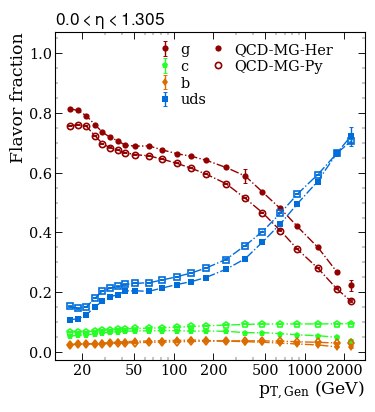

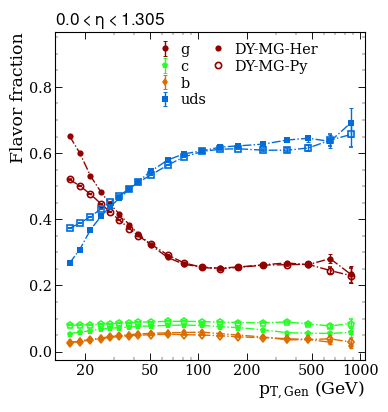

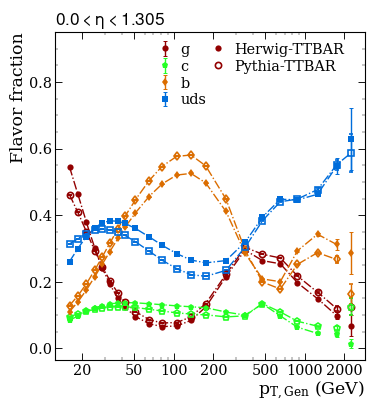

In [394]:
eta_idx = np.searchsorted(etabins_abs,0)
flavors = ['g', 'c', 'b', 'q'] #, 'unmatched']
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# include_unmatched = True
flavors = ['g', 'c', 'b', 'q', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'q']
saveplot = include_unmatched

for ii in range(len(samples)):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    samp = samples[ii]
    sample_plot = {}
    
    for sample in [sampHer, sampPy]:
        output = get_output(sample)
        file_dict = get_file_dict(sample)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, sumeta=False)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', etabins_abs) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])

        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var = {'all': hists_rebinned['all'].variances()/hists_vals['all']**2}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var['all']**2)
        
        Efrac_splines = {key: get_spline(qfracs[key][:,eta_idx]) for key in qfracs.keys() }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(ptbins_c), etabins_c), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]


#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        qfrac_spline_dict[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]

    plot_Efractions(sample_plot, eta_idx, saveplot=saveplot)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}


### Deriving the uncertainties

In [395]:
# pt200bin = np.searchsorted(ptbins,200)

In [396]:
def read_data2(name, sample, flav):
    data = read_data(name, flav, "_L5"+sample+fineetastr)
    data[data==0] = np.nan
    return data

In [397]:
def read_corrections(sample, flav):
    data = read_data("Median", flav, "_L5"+sample+fineetastr)
    data[data==0] = np.nan
    return 1/data

#### Obtain the fitted corrections

In [398]:
# flavors = ['g', 'c', 'b', 'q', 'unmatched']
from coffea.lookup_tools import extractor
corr_loc_Sum20_Py = [f"* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py{fineetastr}_pt30to500.txt"]
corr_loc_Sum20_Her = [f"* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her{fineetastr}_pt30to500.txt"]

ext = extractor()
ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
ext.finalize()
evaluator = ext.make_evaluator()

In [399]:
plt.rcParams['figure.subplot.top'] = 0.93
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.left'] = 0.176

In [400]:
# plt.rcParams['figure.subplot.left']

In [401]:
def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

In [402]:
def poly4lims(x, xmin, xmax, *p):
    xcp = x.copy()
    lo_pos = xcp<xmin
    hi_pos = xcp>xmax
    xcp[lo_pos] = xmin
    xcp[hi_pos] = xmax
    return poly4(xcp, *p)
    
        


In [403]:
def get_ratio(a, b, divide=True):
    '''To obtain the JEC uncertainty instead of dividing Herwig by Python, the samples are subtracted'''
    if divide:
        return(a/b)
    else:
        return(a-b)

In [404]:
color_scheme2 = color_scheme.copy()
color_scheme2['QCD, 3 jets'] = {'color': 'brown', 'marker': 'o'}
color_scheme2['DY, 2 jets'] = {'color': 'cyan', 'marker': 'o'}

In [405]:
def plot_ratio_comparisons_samples(flav, etaidx, fit_samp='J'):
    ''' Put ratio plots of many all flavors at the same place. Reproduce Fig. 31 in arXiv:1607.03663
    '''

    divide=False
    inverse=False   #True if plot corrections, False if plot responses
    use_recopt=False   #True if use reco pt, False if use gen pt
        
    mean_name = "Median"
    mean_name_std = mean_name+'Std'
    start = np.searchsorted(ptbins, 15, side='left')
    end = 27
#     etaidx = np.searchsorted(etabins_abs, 0, side='left')
    
    # tag1 = '_L5_DY-MG-Py'
    # tag2 = '_L5_DY-MG-Her'
#     denom_samples = ['_QCD-MG-Py', '_QCD-MG-Py_leading_jets', '_Pythia-TTBAR', '_DY-MG-Py', '_DY-MG-Py_leading_jets'] #]
#     samples = ['_QCD-MG-Her', '_QCD-MG-Her_leading_jets', '_Herwig-TTBAR', '_DY-MG-Her', '_DY-MG-Her_leading_jets'] #]
#     sample_lab = ['QCD', r'QCD, 3 jets', 'TTBAR', 'DY', r'DY, 2 jets'] #  ]
    denom_samples = ['_QCD-MG-Py', '_Pythia-TTBAR', '_DY-MG-Py'] #]s
    samples = ['_QCD-MG-Her', '_Herwig-TTBAR', '_DY-MG-Her'] #]
    sample_lab = ['QCD', 'TTBAR', 'DY'] #  ]

    
    
    yvals = np.array([read_data2(mean_name, samp, flav)[start:end,etaidx] for samp in samples])
    stds  = np.array([read_data2(mean_name_std, samp, flav)[start:end,etaidx] for samp in samples])
    xvals = np.array([read_data2("MeanRecoPt", samp, flav)[start:end,etaidx] for samp in samples])
    
    yvals_d = np.array([read_data2(mean_name, samp, flav)[start:end,etaidx] for samp in denom_samples])
    stds_d  = np.array([read_data2(mean_name_std, samp, flav)[start:end,etaidx] for samp in denom_samples])
    xvals_d = np.array([read_data2("MeanRecoPt", samp, flav)[start:end,etaidx] for samp in denom_samples])
#     print('etaidx = ', etaidx)

    corr_loc_Sum20_Py = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500.txt"]
    corr_loc_Sum20_Her = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500.txt"]
    ext = extractor()
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
    ext.finalize()
    evaluator = ext.make_evaluator()
        
    yvals[(yvals==0) | (np.abs(yvals)==np.inf)] = np.nan
    yvals_d[(yvals_d==0) | (np.abs(yvals_d)==np.inf)] = np.nan
    
    ratios = get_ratio(yvals, yvals_d, divide)
    if divide==True:
        ratio_unc = ((stds / yvals_d)**2 + (yvals/yvals_d**2 * stds_d)**2)**(1/2)
    else:
        ratio_unc = (stds**2+stds_d**2)**(1/2)
    
    if not use_recopt:
        xvals = ptbins_c[start:end]    
        

    fig, ax = plt.subplots()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        
#     assert False
    for yval, std, samp in zip(ratios, ratio_unc, sample_lab):
        ax.errorbar(xvals, yval, yerr=std,
                    linestyle="none", label=samp, **color_scheme2[samp],
                    capsize=1.6, capthick=0.7, linewidth=1.0)
#         assert not lab == 'unmatched'
       
    for fit_samp, lab in zip(['J', 'T'], ['QCD', 'TTBAR']):
        etaval = etabins_abs[etaidx]+0.001 #to ensure that the correction is applied from the right side of the bin border
        xvals_cont = np.geomspace(np.min(xvals), np.max(xvals), 100)
        yvals_cont = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
        yvals_cont_d = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
        if inverse==True:
            yvals = 1/yvals
            yvals_d = 1/yvals_d
            ### Error propagation
            stds = yvals**2*stds
            stds_d = yvals_d**2*stds_d

        if inverse==False:
            yvals_cont = 1/yvals_cont
            yvals_cont_d = 1/yvals_cont_d


        ratios_cont = get_ratio(yvals_cont, yvals_cont_d, divide)
    #     ax.set_prop_cycle(None)
    #     for yval, flav in zip(ratios_cont, flavors):
        ax.plot(xvals_cont, ratios_cont, markersize=0, **color_scheme[lab], label=lab+' fit')
    
    ax.set_xscale('log')
    xlims = ax.get_xlim()
    
    ax.hlines(1,1, 10000, linestyles='--',color="black", linewidth=1,)
    
    ####################### Fit ####################
    fit_minx = np.searchsorted(ptbins_c, 30, side='left') - 1
    fit_maxx = np.searchsorted(ptbins_c, 500, side='left')
    
    xval4fit = np.tile(xvals[fit_minx:fit_maxx], len(sample_lab))
    yval4fit = np.concatenate(ratios[:,fit_minx:fit_maxx])
    ratio_unc4fit = np.concatenate(ratio_unc[:,fit_minx:fit_maxx])
    validpt_mask = ~(np.isnan(yval4fit) | np.isinf(yval4fit) | (yval4fit==0))
    xval4fit = xval4fit[validpt_mask]
    yval4fit = yval4fit[validpt_mask]
    ratio_unc4fit = ratio_unc4fit[validpt_mask]
    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    min_rel_uncert = 0.001
    if divide == True:
        where_limit_std = (ratio_unc4fit/yval4fit)<min_rel_uncert
        ratio_unc4fit[where_limit_std] = min_rel_uncert*yval4fit[where_limit_std]
    else:
        where_limit_std = ratio_unc4fit<min_rel_uncert
        ratio_unc4fit[where_limit_std] = min_rel_uncert
    
    p_poly4_1, arr = curve_fit(poly4, xval4fit, yval4fit, p0=[ 1, 1, 1, 1, 1])
    p_poly4, arr = curve_fit(poly4, xval4fit, yval4fit, p0=p_poly4_1, sigma=ratio_unc4fit)
#     p_poly4_1, arr = curve_fit(np.tile(xvals,len(sample_lab)), np.concatenate(ratios), means2fit, p0=[ 1, 1, 1, 1, 1])
    xfitmin = xval4fit.min()
    xfitmax = xval4fit.max()
    xplot = np.linspace(xfitmin-(2), xfitmax+300,1000)
    poly4fun = lambda x, p: poly4lims(x, xfitmin, xfitmax, *p)
    y_poly4 = poly4fun(xvals_cont, p_poly4)
    y_poly4_now = poly4fun(xvals_cont, p_poly4_1)
    ax.plot(xvals_cont, y_poly4, label=r'Poly, n=4' ,linewidth=2.0, markersize=0);
#     ax.plot(xvals_cont, y_poly4_now, label=r'Poly,  n=4, no weights' ,linewidth=1.7, markersize=0);
    #, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly4, Ndof_poly4)
    
    ######################## Calculate resonable limits excluding the few points with insane errors
    recalculate_limits=True
    if recalculate_limits:
        yerr_norm = np.concatenate(ratio_unc)
        y_norm = np.concatenate(ratios)
        norm_pos = (yerr_norm<0.01) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
        if ~np.any(norm_pos):
            print("Cannot determine ylimits")
            norm_pos = np.ones(len(yerr_norm), dtype=int)
            raise Exception("Cannot determine ylimits")
        left_lim = np.min((y_norm-yerr_norm)[norm_pos])
        right_lim = np.max((yerr_norm+y_norm)[norm_pos])
        lim_pad = (right_lim - left_lim)/20
        ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad*10)
    
    xlabel = r'$p_{T,reco}$ (GeV)' if use_recopt else r'$p_{T,ptcl}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' if divide else 'Her7-Py8'
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend(ncol=1)
    ax.set_xlim(xlims)
    
    title_name = 'QCD' if fit_samp=='J' else 'ttbar'
    hep.label.exp_text(text=f'$ {etabins_abs[etaidx]}<\eta<{etabins_abs[etaidx+1]}$, {flav} jets', loc=0)
    
    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)
    etastr = f"eta{etabins_abs[etaidx]}to{etabins_abs[etaidx+1]}".replace('.','p')
    fig_name = f'fig/uncertainty/Pythia_Herwig_all_samples_{flav}_jets_{etastr}_{fit_samp}_fits'
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()
    return [p_poly4, xfitmin, xfitmax]

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305_T_fits


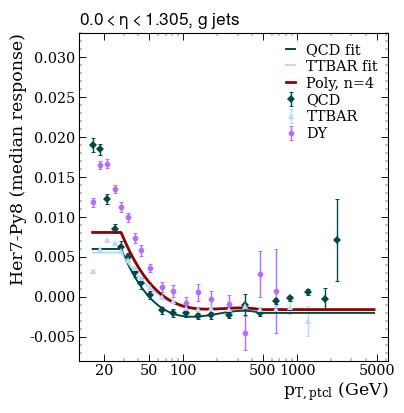

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p305to2p5_T_fits


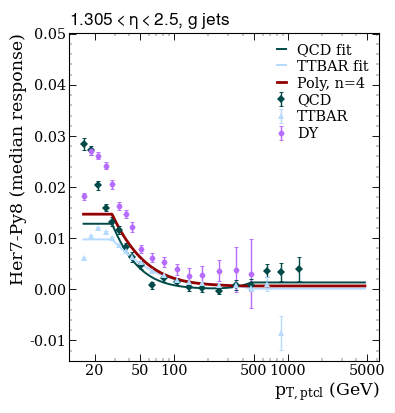

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta2p5to3p139_T_fits


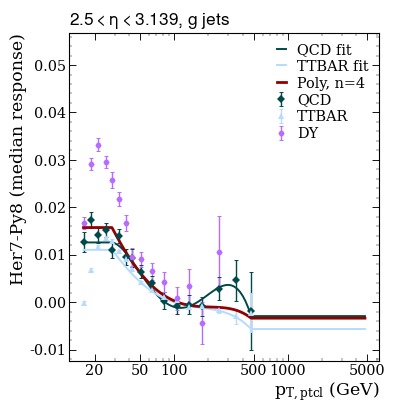

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta3p139to5p191_T_fits


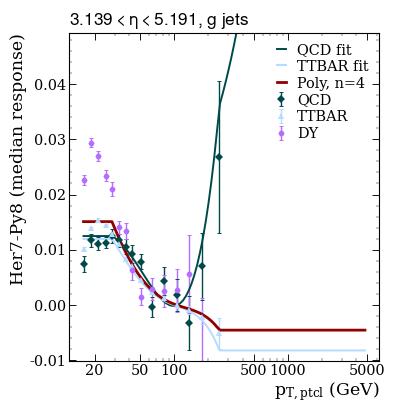

/tmp/anpotreb/ipykernel_9920/205324354.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx=etaidx)


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305_T_fits


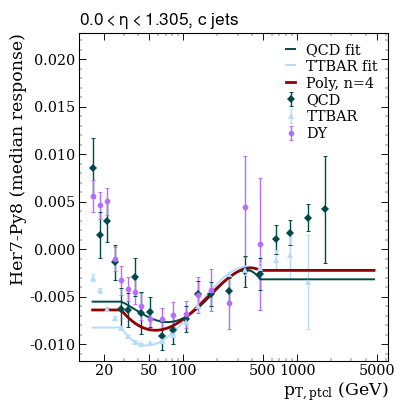

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p305to2p5_T_fits


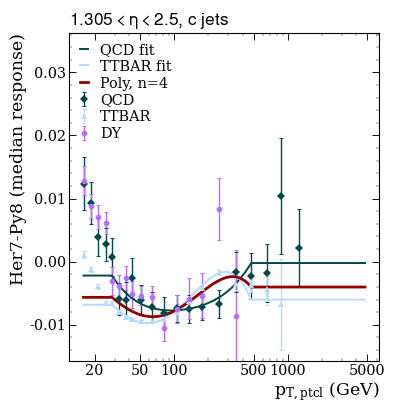

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta2p5to3p139_T_fits


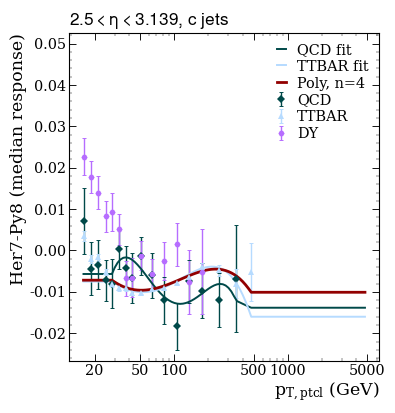

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta3p139to5p191_T_fits


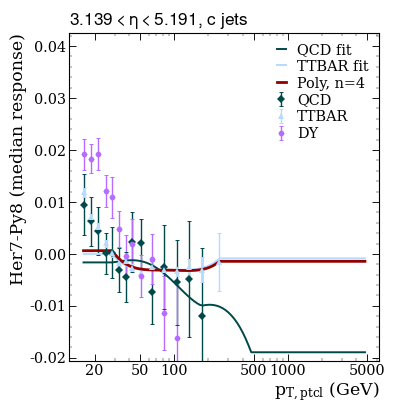

/tmp/anpotreb/ipykernel_9920/205324354.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx=etaidx)


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305_T_fits


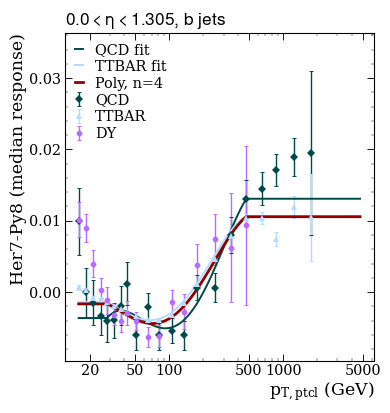

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p305to2p5_T_fits


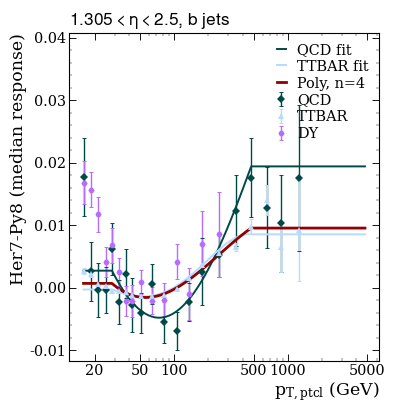

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta2p5to3p139_T_fits


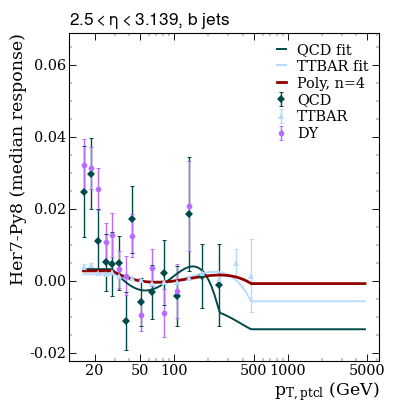

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta3p139to5p191_T_fits


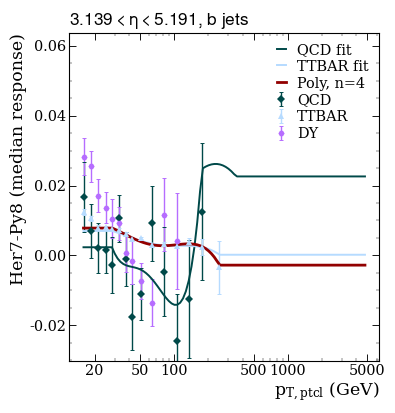

/tmp/anpotreb/ipykernel_9920/205324354.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx=etaidx)


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305_T_fits


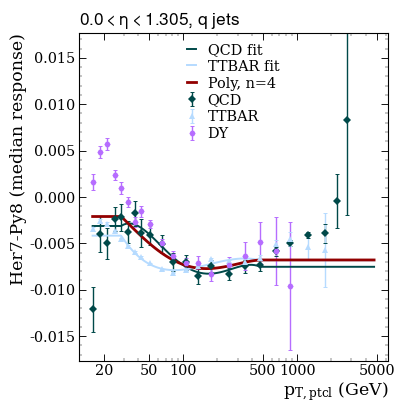

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta1p305to2p5_T_fits


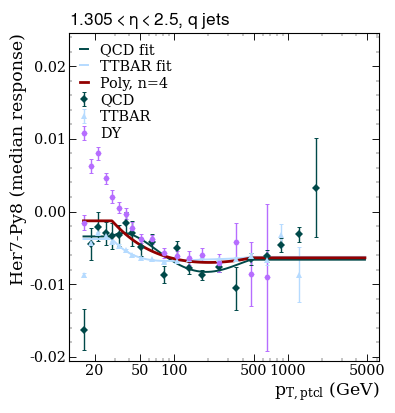

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta2p5to3p139_T_fits


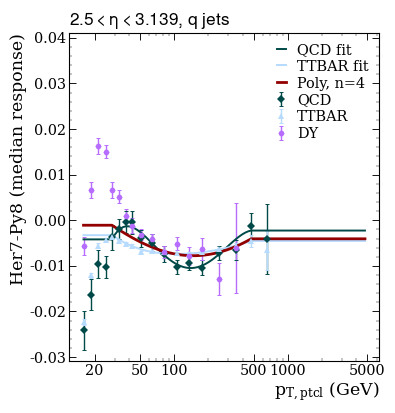

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta3p139to5p191_T_fits


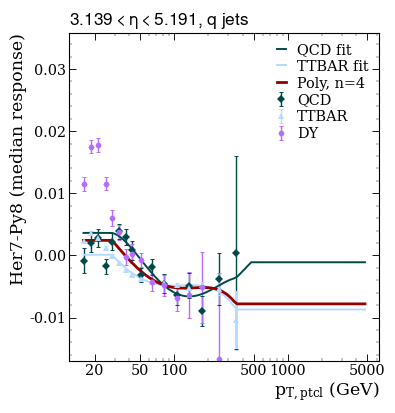

/tmp/anpotreb/ipykernel_9920/205324354.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx=etaidx)


In [406]:
fit_res_ratio = {}
for flav in flavors[:4]:
    fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx=etaidx) 
                                for etaidx in range(len(etabins_c))])
    fit_res_ratio[flav] = fit_res_tmp

In [407]:
def plot_all_flavor_comparison(num_sample_name,
                         denom_sample_name, fit_samp='J', etaidx=0):
    ''' Put ratio plots of many all flavors at the same place. Reproduce Fig. 31 in arXiv:1607.03663
    '''

    inverse=False   #True if plot corrections, False if plot responses
    use_recopt=False   #True if use reco pt, False if use gen pt
    flavors = ['g', 'q' ,'c', 'b'] #, 'unmatched']
    
    mean_name = "Median"
    mean_name_std = mean_name+'Std'
    start = np.searchsorted(ptbins, 15, side='left')
#     etaidx = np.searchsorted(etabins_abs, 0, side='left')
    
    yvals = np.array([read_data2(mean_name, num_sample_name, flav)[start:,etaidx] for flav in flavors])
    stds  = np.array([read_data2(mean_name_std, num_sample_name, flav)[start:,etaidx] for flav in flavors])
    xvals = np.array([read_data2("MeanRecoPt", num_sample_name, flav)[start:,etaidx] for flav in flavors])
    
    yvals_d = np.array([read_data2(mean_name, denom_sample_name, flav)[start:,etaidx] for flav in flavors])
    stds_d  = np.array([read_data2(mean_name_std, denom_sample_name, flav)[start:,etaidx] for flav in flavors])
    xvals_d = np.array([read_data2("MeanRecoPt", denom_sample_name, flav)[start:,etaidx] for flav in flavors])
#     print('etaidx = ', etaidx)

    corr_loc_Sum20_Py = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500.txt"]
    corr_loc_Sum20_Her = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500.txt"]
    ext = extractor()
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
    ext.finalize()
    evaluator = ext.make_evaluator()
        
    yvals[(yvals==0) | (np.abs(yvals)==np.inf)] = np.nan
    yvals_d[(yvals_d==0) | (np.abs(yvals_d)==np.inf)] = np.nan
    
    ratios = yvals/yvals_d
    ratio_unc = ((stds / yvals_d)**2 + (yvals/yvals_d**2 * stds_d)**2)**(1/2)
    
    if not use_recopt:
        xvals = ptbins_c[start:]    
        
    etaval = etabins_abs[etaidx]+0.001 #to ensure that the correction is applied from the right side of the bin border
    xvals_cont = np.geomspace(np.min(xvals), np.max(xvals), 100)
    yvals_cont = np.array([evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
                           for flav in flavors])
    yvals_cont_d = np.array([evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
                       for flav in flavors])
    if inverse==True:
        yvals = 1/yvals
        yvals_d = 1/yvals_d
        ### Error propagation
        stds = yvals**2*stds
        stds_d = yvals_d**2*stds_d
        
    if inverse==False:
        yvals_cont = 1/yvals_cont
        yvals_cont_d = 1/yvals_cont_d
    
    
    fig, ax = plt.subplots()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        
#     assert False
    for yval, std, flav in zip(ratios, ratio_unc, flavors):
        ax.errorbar(xvals, yval, yerr=std,
                    linestyle="none", label=leggend_dict[flav], **color_scheme[flav],
                    capsize=1.6, capthick=0.7, linewidth=1.0)
#         assert not lab == 'unmatched'
       
    ratios_cont = yvals_cont/yvals_cont_d
#     ax.set_prop_cycle(None)
    for yval, flav in zip(ratios_cont, flavors):
        ax.plot(xvals_cont, yval, markersize=0, **color_scheme[flav])
    
    ax.set_xscale('log')
    xlims = ax.get_xlim()
    
    ax.hlines(1,1, 10000, linestyles='--',color="black", linewidth=1,)
    ######################## Calculate resonable limits excluding the few points with insane errors
    recalculate_limits=True
    if recalculate_limits:
        yerr_norm = np.concatenate(ratio_unc)
        y_norm = np.concatenate(ratios)
        norm_pos = (yerr_norm<0.01) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
        if ~np.any(norm_pos):
            print("Cannot determine ylimits")
            norm_pos = np.ones(len(yerr_norm), dtype=int)
            raise Exception("Cannot determine ylimits")
        left_lim = np.min((y_norm-yerr_norm)[norm_pos])
        right_lim = np.max((yerr_norm+y_norm)[norm_pos])
        lim_pad = (right_lim - left_lim)/20
        ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad*8)
    
    xlabel = r'$p_{T,reco}$ (GeV)' if use_recopt else r'$p_{T,ptcl}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' 
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend(ncol=1)
    ax.set_xlim(xlims)
    
    title_name = 'QCD' if fit_samp=='J' else 'ttbar'
    hep.label.exp_text(text=f'$ {etabins_abs[etaidx]}<\eta<{etabins_abs[etaidx+1]}$, {title_name}', loc=0)
    
    etastr = f"eta{etabins_abs[etaidx]}to{etabins_abs[etaidx+1]}".replace('.','p')
    fig_name = f'fig/uncertainty/Pythia_Herwig_ratio_{etastr}_using_{fit_samp}_fits'
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show();

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta0p0to1p305_using_T_fits


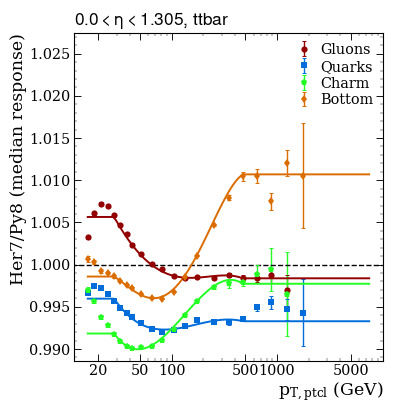

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta0p0to1p305_using_J_fits


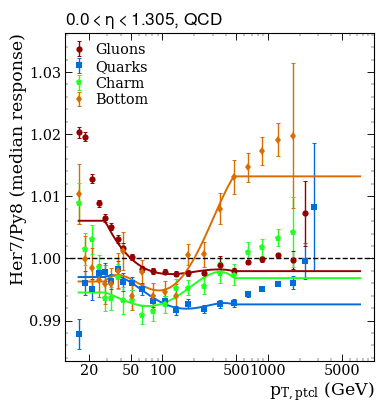

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta1p305to2p5_using_T_fits


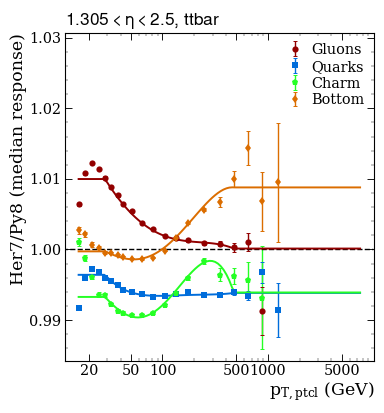

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta1p305to2p5_using_J_fits


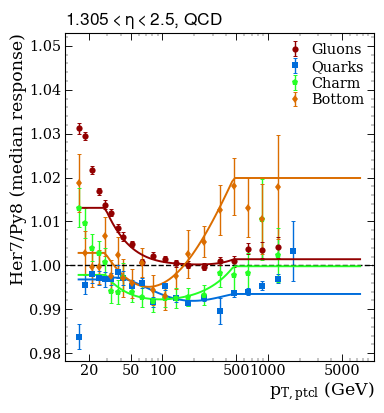

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta2p5to3p139_using_T_fits


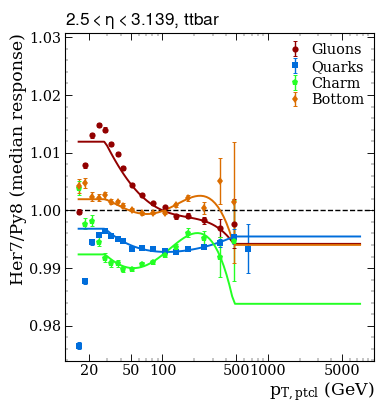

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta2p5to3p139_using_J_fits


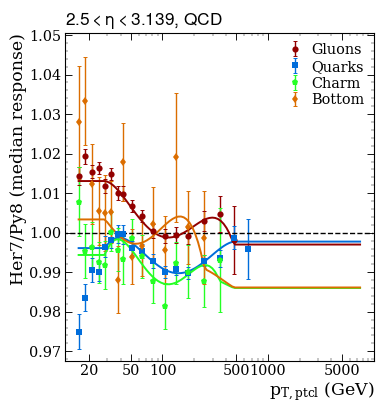

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta3p139to5p191_using_T_fits


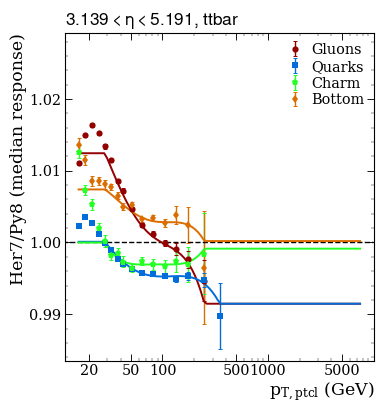

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_ratio_eta3p139to5p191_using_J_fits


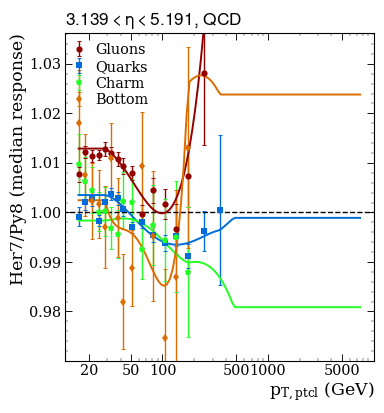

In [408]:
for etaidx in range(len(etabins_c)):
    plot_all_flavor_comparison('_Herwig-TTBAR', '_Pythia-TTBAR', 'T',etaidx)
    plot_all_flavor_comparison('_QCD-MG-Her', '_QCD-MG-Py', "J",etaidx )

### Resum all the flavors for each sample

In [409]:
fineetastr = ''

In [410]:
def get_evaluator_pre(sample='Her', flavor='b' , inverse=False, use_corrections='J'):
    ''' inverse==True gets a correction, inverse==False gets a response.
    evaluator obtains corrections directly
    '''
    eva = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_{sample}{fineetastr}_pt30to500_{flavor}{use_corrections}']
    if inverse==True:
        return eva
    else:
        return lambda a,b: 1/eva(a,b)

In [411]:
def resum_to_mix(Efracspline, samp, etavals, ptvals, pteta_grid):
    ''' Sum up the corrections from the fit according to the flavor fractions in `Efracspline`.
    samp = 'Her' or 'Py' for Herwig corrections or for Pythia corrections
    '''
    ### Hard coded limits for the uncertainties
    if not isinstance(ptvals, Iterable):
        ptvals = np.array([ptvals])      
#     if not (type(ptvals) is list) or (type(ptvals) is np.ndarray):
    if not isinstance(etavals, Iterable): #(type(etaidx) is list) or (type(etaidx) is np.ndarray):
        etaidxs = np.array([etavals])
    ptvals = ptvals.copy()
    ptvals[ptvals<30]=30
    ptvals[ptvals>500]=500
#     print(f'ptvals called for samp = {samp}. {ptvals}')
#     print(f'ptvals for samp = {samp}. {ptvals}')
    
    
    response = get_evaluator(samp, flavors[0])(etavals, ptvals)
    Her_spline = response*Efracspline[flavors[0]](pteta_grid)
    for flav in flavors[1:4]:
        response = get_evaluator(samp, flav)(etavals, ptvals)
        Her_splineNew = (response*Efracspline[flav](pteta_grid))
        Her_spline += Her_splineNew
    return Her_spline

In [541]:
def get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0):
    result = {}
    result["g20q80"] = get_ratio(
        resum_to_mix(qfrac_spline_dict['_DY-MG-Her'], 'Her', etavals, ptvals, (np.log10(200),etabins_c[0])),
        resum_to_mix(qfrac_spline_dict['_DY-MG-Py'], 'Py', etavals, ptvals, (np.log10(200),etabins_c[0])),
        divideHerPy
    )

    result["g20q80_fixed"] = get_ratio(
        resum_to_mix(qfrac_spline_dict['_DY-MG-Her'], 'Her', 0, 200, (np.log10(200),etabins_c[0])),
        resum_to_mix(qfrac_spline_dict['_DY-MG-Py'], 'Py', 0, 200, (np.log10(200),etabins_c[0])),
        divideHerPy
        )

    for flav in ['q', 'g', 'b', 'c']:
        result[flav+'100'] = get_ratio(
                                get_evaluator("Her", flav)(etavals, ptvals),
                                get_evaluator("Py",  flav)(etavals, ptvals),
                                divideHerPy
                                 ) 

    ptvals2 = ptvals.copy()
    ptvals2[ptvals2<30]=30
    ptvals2[ptvals2>500]=500
    pteta_grid = (np.log10(ptvals2), etavals)
        
    Rdijet0 = get_ratio(resum_to_mix(qfrac_spline_dict['_QCD-MG-Her'], 'Her', etavals0, ptvals2, pteta_grid0),
              resum_to_mix(qfrac_spline_dict['_QCD-MG-Py'], 'Py', etavals0, ptvals2, pteta_grid0),
              divideHerPy)

    result["Rref"] = result["g20q80_fixed"] + (HerPy_differences['QCD'][0] - Rdijet0)
    
    return result

In [542]:
def create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=False):
    if inverse==True:
        a = read_corrections(sampHer, 'all')
        b = read_corrections(sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a*b)**2+(delta_b*b**2/a)**2)[pt_idxs,eta_idxs]
        else:
            corrstd_all = np.sqrt((delta_a*a**2)**2+(delta_b*b**2)**2)[pt_idxs,eta_idxs]
    else:
        a = read_data2('Median', sampHer, 'all')
        b = read_data2('Median', sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
        else:
            corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
    return [corr_all, corrstd_all]

In [543]:
def plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretaidx, plotvspt=False):
    addc = additional_uncertainty_curves
    fig, ax = plt.subplots()

#     print("addc", -addc['Rref'].T*100)
#     print("HerPydiff", HerPy_differences['QCD'][0]*100)
#     print("sum", (HerPy_differences['QCD'][0]-addc['Rref'])*100)
    xvals = ptvals if plotvspt else etavals
    old_uncs = []
    for samp in ['QCD', 'DY']:    
        old_unc = ax.plot(xvals, (uncertainties[samp](etavals, ptvals)[:,0]-1)*100, '-.', markersize=0, linewidth=1.0,
                **color_scheme[samp], alpha=0.6)
        ax.plot(xvals, (HerPy_differences[samp][0]-addc['Rref'])*100, linestyle=(2, (4, 2)), label=samp, markersize=0,
                linewidth=1.2, **color_scheme[samp])
        old_uncs.append(old_unc[0])

#     next(ax._get_lines.prop_cycler) ## allign colors with plot_HerPydiff (skip 20%glu)
    for flav in ['g', 'q', 'b', 'c']:
        lab = leggend_dict[flav]
        old_unc = ax.plot(xvals, (uncertainties[flav](etavals, ptvals)[:,0]-1)*100, '-.', markersize=0, linewidth=1.0,
                **color_scheme[flav], alpha=0.6)
        ax.plot(xvals, (addc[f'{flav}100']-addc['Rref'])*100, label=lab, markersize=0, linewidth=1.2,
                **color_scheme[flav])
        old_uncs.append(old_unc[0])
#     ax.plot(xvals, (addc['q100']-addc['Rref'])*100, label='Quarks', markersize=0, linewidth=1.2)
#     ax.plot(xvals, (addc['b100']-addc['Rref'])*100, label='Bottom', markersize=0, linewidth=1.2)
#     val_glu = flav_evaluator['Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureGluon'](etavals, ptvals)[:,0]
#     ax.plot(xvals, (1-val_glu)*100, label='Gluons old', markersize=0, linewidth=1.2)
    
    vlinecoord = 1 if divideHerPy else 0
    ax.hlines(vlinecoord, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='--',color="gray",
        linewidth=1, alpha=0.5)

#     legloc = 'upper left' if plotvspt else 'upper right'
#     legloc = 'upper left' if plotvspt else 'upper right'
    legend1 = ax.legend(old_uncs, ['']*len(old_uncs), loc='upper right', bbox_to_anchor=(0.52, 1), handlelength=1.5, title='Run 1', title_fontsize=10)
    leg2 = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0.47, 1), handlelength=0.9, title='Run 2' , title_fontsize=10)#, title='assembled\nfrom QCD', title_fontsize=10)
    ax.add_artist(legend1)
    xlabel = r'$p_{T}$ (GeV)' if plotvspt else r'$\eta$'
    ax.set_xlabel(xlabel);
    ylabel = 'JEC uncertainty (%)'
    ax.set_ylabel(ylabel);
    if plotvspt:
        ax.set_xscale('log')
        ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.set_xlim(15,1000)

    # ax.set_ylim(0.9885,1.0205)
    ylim_old = ax.get_ylim()
    ylim_pad = (ylim_old[1]-ylim_old[0])*0.4 if plotvspt else (ylim_old[1]-ylim_old[0])*0.62
    ax.set_ylim(ylim_old[0],ylim_old[1]+ylim_pad)
    labtxt = f'$\eta$ = {etabins_abs[ptoretaidx]}' if plotvspt else f'$p_T$ = {ptbins_c[ptoretaidx]} GeV'
    hep.label.exp_text(text=labtxt, loc=0)
    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)

    if plotvspt:
        fig_name = figdir+f"/JECuncertainty_vs_pt_eta_{etabins_abs[ptoretaidx]}".replace('.','')
    else:
        fig_name = figdir+f"/JECuncertainty_vs_pt_pt_{ptbins_c[ptoretaidx]}".replace('.','_')
    print("Saving plot with the name = ", fig_name+".pdf / .png")
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');

    1;

In [544]:
def plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, etaidx):
    addc = additional_uncertainty_curves
    fig, ax = plt.subplots()

    lines = []
    markers = []
    for samp in ['QCD', 'DY', 'TTBAR']:    
#         mc = next(ax._get_lines.prop_cycler)
        line = ax.plot(ptvals, HerPy_differences[samp][0], linestyle=(0, (3.3, 2)), markersize=0, **color_scheme[samp], linewidth=1.2)
        marker = ax.errorbar(ptbins_c, HerPy_differences[samp][1], yerr=HerPy_differences[samp][2],
                           linestyle='none', **color_scheme[samp], capsize=1.6, capthick=0.7, linewidth=1.0)
        lines.append(line[0])
        markers.append(marker[0])
        
    pointsg20 = ax.plot(ptvals, addc['g20q80'], label='DY at 200 GeV', markersize=0, linewidth=1.2, **color_scheme["DY200"])
    for flav in ['g', 'q', 'b', 'c']:
        lab = leggend_dict[flav]
        ax.plot(ptvals, addc[f'{flav}100'], label=lab, markersize=0, linewidth=1.2, **color_scheme[flav])
#         ax.plot(ptvals, addc['q100'], label='Quarks', markersize=0, linewidth=1.2)
#         ax.plot(ptvals, addc['b100'], label='Bottom', markersize=0, linewidth=1.2)

    vlinecoord = 1 if divideHerPy else 0
    ax.hlines(vlinecoord ,1, 10000, linestyles='--',color="gray",
        linewidth=1, alpha=0.5)

    ax.hlines(addc['g20q80_fixed'], 1, 10000, linestyles='--',color=color_scheme["DY200"]['color'],
        linewidth=1, alpha=0.9)

    leg1_handles = [(ai,bi) for ai, bi, in zip(lines,markers)]
    legend1 = ax.legend(leg1_handles, ['QCD', 'DY', 'TTBAR'], loc="upper right", bbox_to_anchor=(0.52, 1), handlelength=1.5) # seg.len=5) #, title='correction', title_fontsize=10)
#     assert False
    leg2 = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0.48, 1))#, title='assembled\nfrom QCD', title_fontsize=10)
    ax.add_artist(legend1)
    xlabel = r'$p_{T}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' if divideHerPy else 'Her7-Py8'
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    ax.set_xscale('log')
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.set_ylim(0.9885,1.0205)
    ax.set_xlim(15,1000)
    ylim_old = ax.get_ylim()
    ylim_pad = (ylim_old[1]-ylim_old[0])*0.3
    ax.set_ylim(ylim_old[0],ylim_old[1]+ylim_pad)

    hep.label.exp_text(text=f'$\eta$ = {etabins_abs[etaidx]}', loc=0)

    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)
    add_name = '/Herwig_Pythia_ratio' if divideHerPy else '/Herwig_Pythia_difference'
    fig_name = figdir+add_name+f'_{etabins_abs[etaidx]}'.replace('.','')
    print("Saving plot with the name = ", fig_name+".pdf / .png")
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');

1;

In [545]:
from collections.abc import Iterable

In [546]:
def evaluate_Her_Py_ratio(etavals, ptvals, flav):
    etaidxs = np.searchsorted(etabins_abs, etavals, side='right')-1
    if not isinstance(ptvals, Iterable):
        ptvals = [ptvals]      
#     if not (type(ptvals) is list) or (type(ptvals) is np.ndarray):
    if not isinstance(etaidxs, Iterable): #(type(etaidx) is list) or (type(etaidx) is np.ndarray):
        etaidxs = [etaidxs]
    fit_res = fit_res_ratio[flav][etaidxs]
    return np.array([poly4lims(np.array([ptval]), xfitmin, xfitmax, *p) for ptval, (p, xfitmin, xfitmax) in zip(ptvals, fit_res)]).T


def resum_to_mix_from_ratio(etavals, ptvals, pteta_grid, Efracspline, Efracspline2=None):
    '''To do:
    include averaging over the Py/Her sample fractions.
    Sum up the corrections from the fit according to the flavor fractions in `Efracspline`.
    '''
    response = evaluate_Her_Py_ratio(etavals, ptvals, flavors[0])
    if Efracspline2==None:
        spline_sum = response*Efracspline[flavors[0]](pteta_grid)
    else:
        spline_sum = response*(Efracspline[flavors[0]](pteta_grid)+Efracspline2[flavors[0]](pteta_grid))/2
    for flav in flavors[1:4]:
        response = evaluate_Her_Py_ratio(etavals, ptvals, flav)
        if Efracspline2==None:
            spline_sum_New = (response*Efracspline[flav](pteta_grid))
        else:
            spline_sum_New = response*(Efracspline[flav](pteta_grid)+Efracspline2[flav](pteta_grid))/2
        spline_sum += spline_sum_New
    return spline_sum.T

def get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0, pteta_grid0):
    result = {}
    result["g20q80"] = resum_to_mix_from_ratio(etavals, ptvals, (np.log10(200), etabins_c[0]),
                                               qfrac_spline_dict['_DY-MG-Her'], qfrac_spline_dict['_DY-MG-Py'])
  
    result["g20q80_fixed"] = resum_to_mix_from_ratio(0, 200, (np.log10(200), etabins_c[0]),
                                               qfrac_spline_dict['_DY-MG-Her'], qfrac_spline_dict['_DY-MG-Py'])
  
    
    ptvals2 = ptvals.copy()
    ptvals2[ptvals2<30]=30
    ptvals2[ptvals2>500]=500
    pteta_grid = (np.log10(ptvals2), etavals)
    
    for flav in ['q', 'g', 'b', 'c']:
        result[flav+'100'] = evaluate_Her_Py_ratio(etavals, ptvals2, flav).T

    Rdijet0 = resum_to_mix_from_ratio(etavals0, ptvals2, pteta_grid0,
                                               qfrac_spline_dict['_QCD-MG-Her'], qfrac_spline_dict['_QCD-MG-Py'])
    
    fig, ax = plt.subplots()
    ax.plot(ptvals, Rdijet0)
    ax.set_xscale('log')

#     fig, ax = plt.subplots()
#     ax.plot(ptvals, result["g20q80_fixed"])
#     ax.set_xscale('log')
    
    result["Rref"] = result["g20q80_fixed"] + (HerPy_differences['QCD'][0] - Rdijet0)
    
    return result

In [547]:
# qfrac_spline_dict[sampHer]['b'](pteta_grid).shape
# evaluate_Her_Py_ratio(etavals, ptvals, 'b').shape

In [548]:
# np.array(evaluate_Her_Py_ratio(etavals, ptvals, 'b'))

In [549]:
# plt.rcParams['figure.subplot.left'] = 0.18

In [550]:
# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     if plotvspt:
#         ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
#         etaidx = np.searchsorted(etabins_c,plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*etabins_c[etaidx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = range(len(ptbins_c))
#         eta_idxs = etaidx
#     else:    
#         etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
#         ptidx = np.searchsorted(ptbins_c,plot_val)
#         ptvals = np.ones(len(etavals))*ptbins_c[etaidx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = ptidx
#         eta_idxs = range(len(etabins_abs))
    
    
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)

In [551]:
from coffea.lookup_tools import extractor
unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.junc.txt"]

ext = extractor()
ext.add_weight_sets(unc)
ext.finalize()
flav_evaluator = ext.make_evaluator()

# flav_evaluator['Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureGluon'](etavals, ptvals)[:,0]

In [552]:
lab_to_flav = {"DY" : "FlavorZJet",
               "QCD": "FlavorQCD",
               "GammaJet": "FlavorPhotonJet",
               "q":   "FlavorPureQuark",
               "c":   "FlavorPureCharm",
               "b":   "FlavorPureBottom",
               "g":   "FlavorPureGluon",
               }

# def get_uncertainties():
uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_{lab_to_flav[key]}']
                   for key in lab_to_flav}

In [553]:
# txtfile_inname = 'Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt'
# txtfile_outname = 'Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_Run2Flavor.txt'

# with open(txtfile_inname, 'r') as file_in:
#     with open(txtfile_outname, 'w') as file_out:
#         file_in.
        
#     file.write(header_txt+'\n')

In [554]:
# dir(evaluator)
# # 'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPhotonJet',
# #  'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureBottom',
# #  'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureCharm',
# #  'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureGluon',
# #  'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureQuark',
# #  'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorQCD',
# 'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorZJet'

In [555]:
etabins_uncert = np.array([-5.4, -5. , -4.4, -4. , -3.5, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
       -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
        0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
        2.6,  2.8,  3. ,  3.5,  4. ,  4.4,  5. ,  5.4])

ptbins_uncert = np.array([   9. ,   11. ,   13.5,   16.5,   19.5,   22.5,   26. ,   30. ,
         34.5,   40. ,   46. ,   52.5,   60. ,   69. ,   79. ,   90.5,
        105.5,  123.5,  143. ,  163.5,  185. ,  208. ,  232.5,  258.5,
        286. ,  331. ,  396. ,  468.5,  549.5,  639. ,  738. ,  847.5,
        968.5, 1102. , 1249.5, 1412. , 1590.5, 1787. , 2003. , 2241. ,
       2503. , 2790.5, 3107. , 3455. , 3837. , 4257. , 4719. , 5226.5,
       5784. , 6538. ])

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_00.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_00.pdf / .png
Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_1305.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1305.pdf / .png
Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_25.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_25.pdf / .png
Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference_3139.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_3139.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_16_0.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_21_5.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_32_5.pdf / .png
Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt

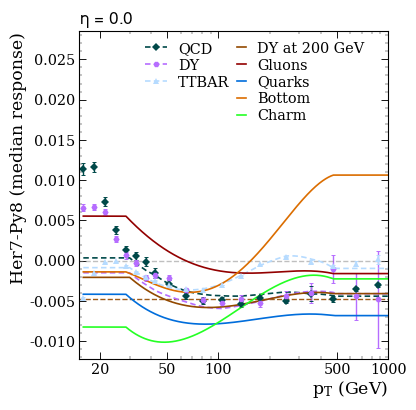

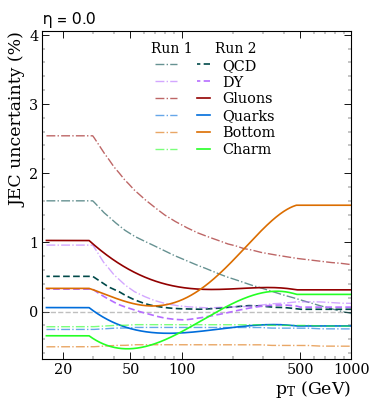

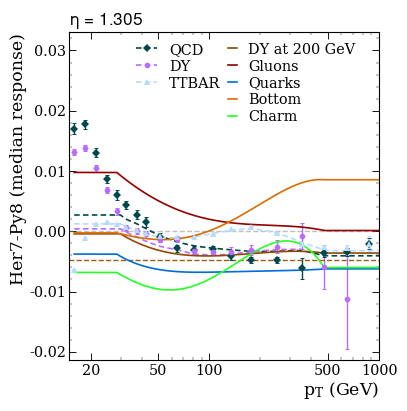

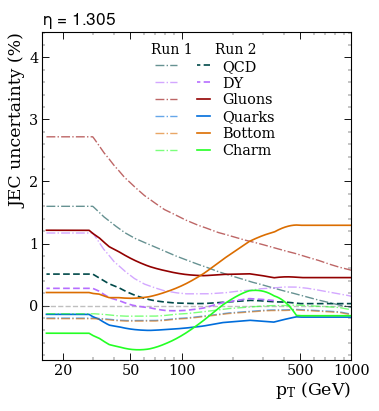

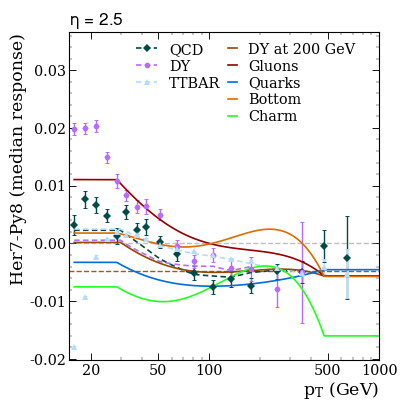

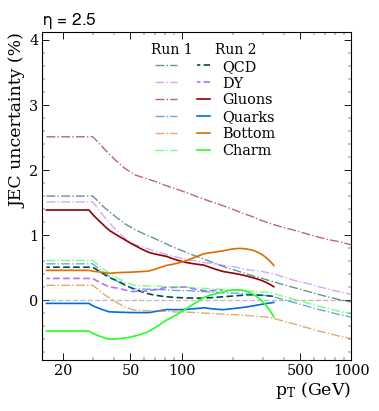

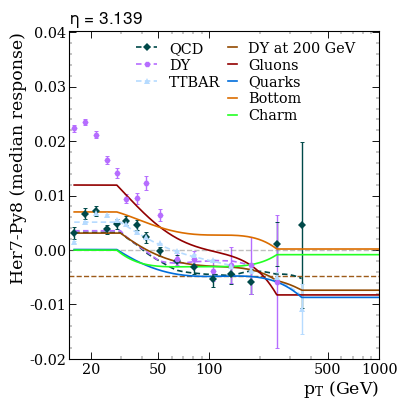

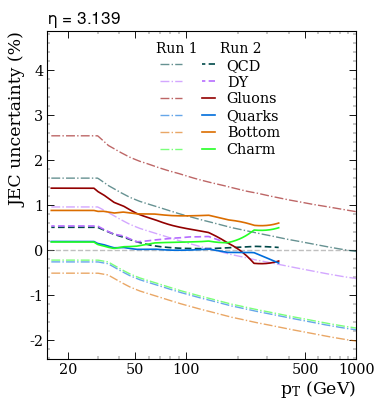

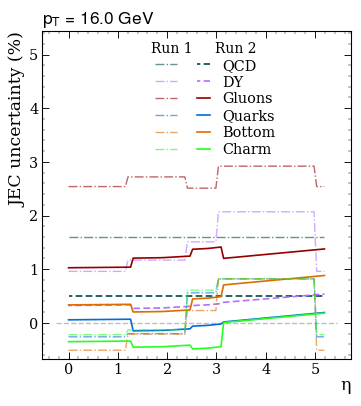

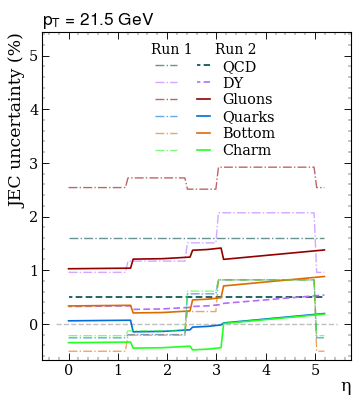

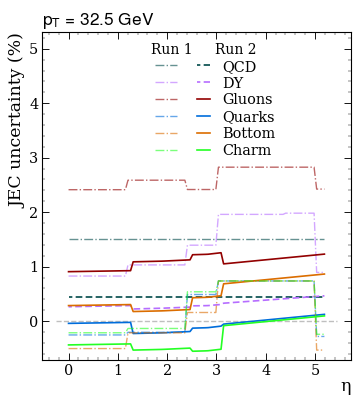

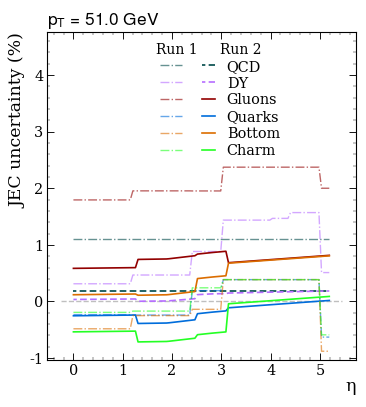

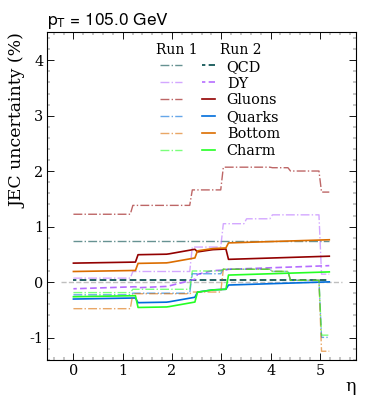

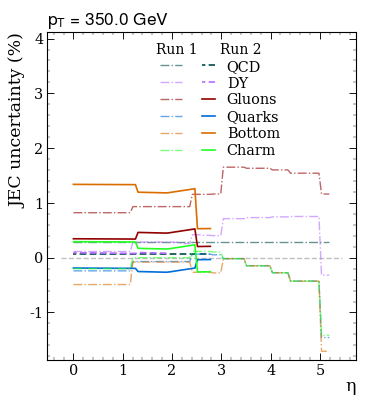

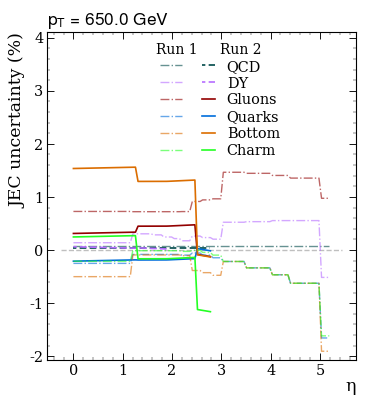

In [560]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'T'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     print(f"plot val {plot_val}, plotvspt {plotvspt}")
    if plotvspt:
        ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
        idx = np.searchsorted(etabins_c,plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*etabins_c[idx]
        pt_idxs = range(len(ptbins_c))
        eta_idxs = idx
    else:    
        etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
        idx = np.searchsorted(ptbins_c,plot_val)
        ptvals = np.ones(len(etavals))*ptbins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(len(etabins_abs)-1)

    ptvals2 = ptvals.copy()
    ptvals2[ptvals2<30]=30
    ptvals2[ptvals2>500]=500
    pteta_grid = (np.log10(ptvals2), etavals)

    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
    etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
    pteta_grid0 = (np.log10(ptvals2), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
              resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
              divideHerPy)
#         HerPy_spline = resum_to_mix_from_ratio(etavals, ptvals, pteta_grid,
#                                                qfrac_spline_dict[sampHer], qfrac_spline_dict[sampPy])

        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
#     additional_uncertainty_curves = get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0, pteta_grid0)
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

In [428]:
plotvspt_ls
plotvspt

[True, True, True, True]

True

In [374]:
HerPy_differences['DY']

[array([1.05952408, 1.05874109, 1.05795946, 1.05717919, 1.05640026,
        1.05562268, 1.05484645, 1.05407156, 1.05329801, 1.05252579,
        1.0517549 , 1.05098533, 1.05021709, 1.04945017, 1.04868457,
        1.04792028, 1.0471573 , 1.04639562, 1.04563525, 1.04487618,
        1.0441184 , 1.04336192, 1.04260673, 1.04185282, 1.0414111 ,
        1.04140434, 1.04139758, 1.04139082, 1.04138407, 1.04137731,
        1.04137056, 1.04136381, 1.04135707, 1.04135032, 1.04134358,
        1.04133684, 1.0413301 , 1.04132337, 1.04131664, 1.0413099 ,
        1.04130318, 1.04129645, 1.04128972, 1.041283  , 1.04127628,
        1.04126956, 1.04126285, 1.04125614, 1.04125118, 1.04155712,
        1.04186319, 1.04216939, 1.04247572, 1.04278219, 1.04308878,
        1.0433955 , 1.04370236, 1.04400935, 1.04431646, 1.04462372,
        1.0449311 , 1.04523861, 1.04554626, 1.04585403, 1.04616194,
        1.04646998, 1.04677816, 1.04708646, 1.0473949 , 1.04770347,
        1.04801217, 1.04832101, 1.04862998, 1.04

In [343]:
# (array([  16. ,   18.5,   21.5,   25. ,   28.5,   32.5,   37.5,   42.5,
#          51. ,   64.5,   81. ,  105. ,  135. ,  175. ,  250. ,  350. ,
#         475. ,  650. ,  875. , 1250. , 1750. , 2250. , 2750. , 3250. ,
#        3750. , 4250. , 4750. , 7500. ]), 2)

In [ ]:
sampHer = '_Herwig-TTBAR'
sampPy = '_QCD-MG-Py'

use_corrections = 'T'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0] #/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

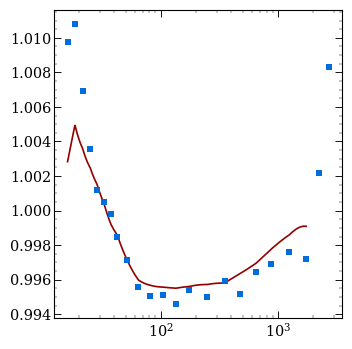

In [53]:
sampHer = '_QCD-MG-Her'
sampPy = '_QCD-MG-Py'

use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0]/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

Saving plot with the name =  ../fig/uncertainty/Herwig_Pythia_difference_00.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_eta_00.pdf / .png
Saving plot with the name =  ../fig/uncertainty/Herwig_Pythia_difference_1305.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_eta_1305.pdf / .png
Saving plot with the name =  ../fig/uncertainty/Herwig_Pythia_difference_25.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_eta_25.pdf / .png
Saving plot with the name =  ../fig/uncertainty/Herwig_Pythia_difference_3139.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_eta_3139.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_pt_16_0.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_pt_21_5.pdf / .png
Saving plot with the name =  ../fig/uncertainty/JECuncertainty_vs_pt_pt_32_5.pdf / .png
Saving plot with the name =  ../

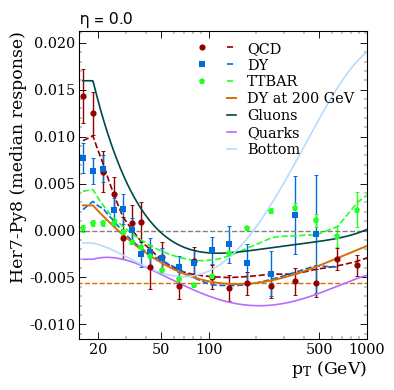

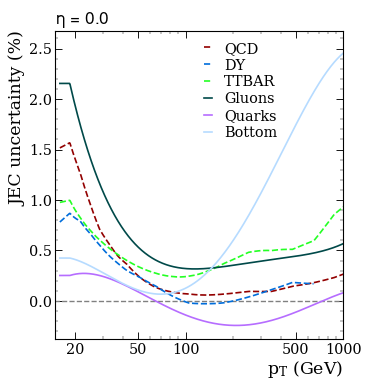

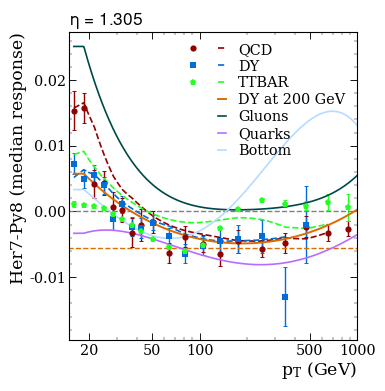

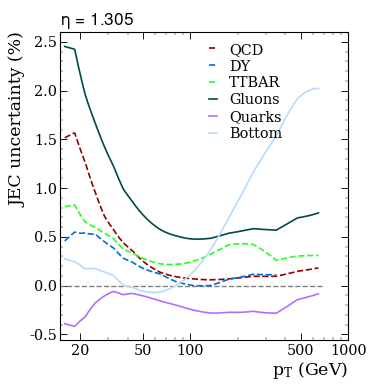

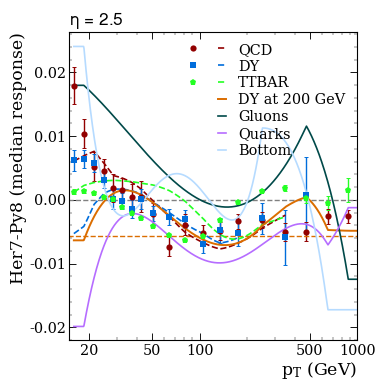

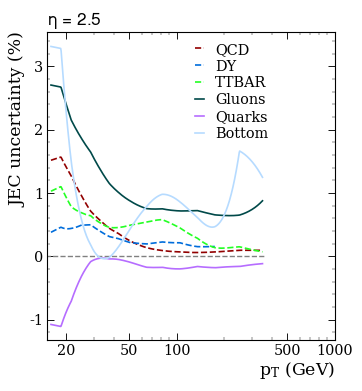

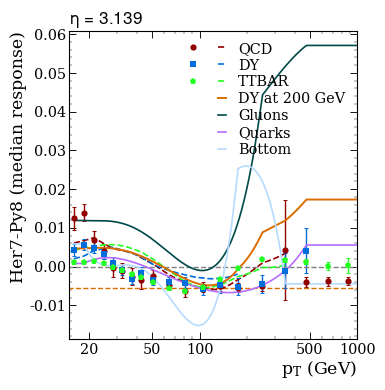

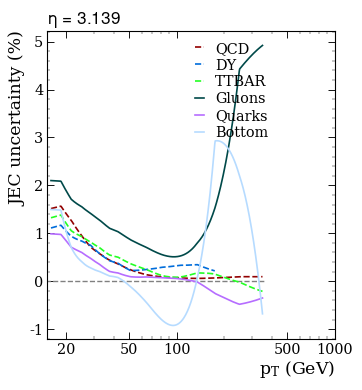

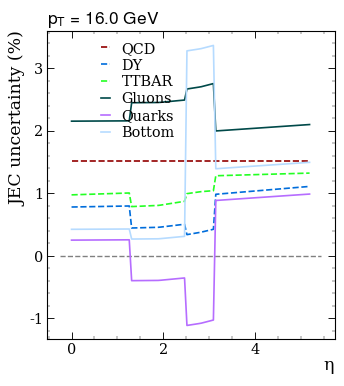

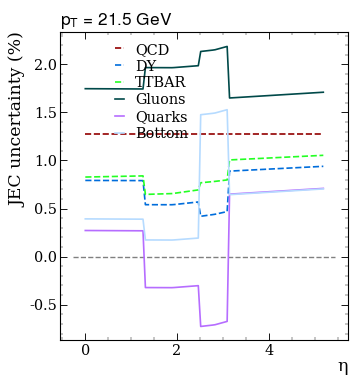

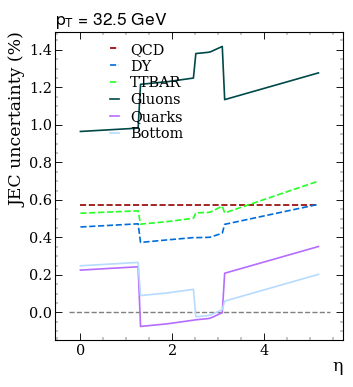

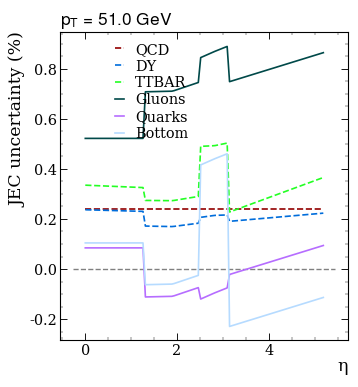

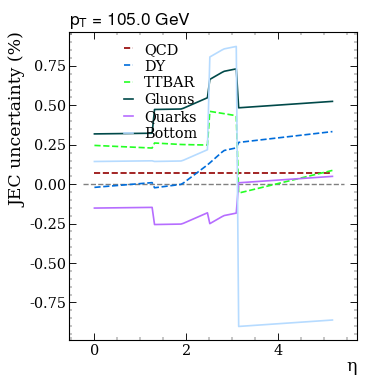

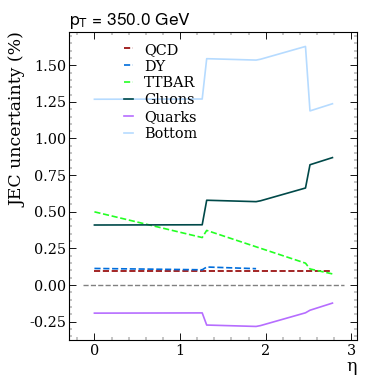

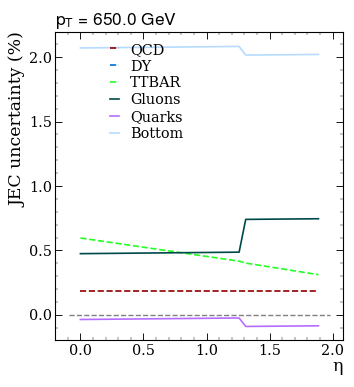

In [253]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals =  etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False
plotvspt = False
use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
        idx = np.searchsorted(etabins_c,plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*etabins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = range(len(ptbins_c))
        eta_idxs = idx
    else:    
        etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
        idx = np.searchsorted(ptbins_c,plot_val)
        ptvals = np.ones(len(etavals))*ptbins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(len(etabins_abs))

    etaidx0=0 
    etavals0 = np.ones(len(ptvals))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
    etavals02 = np.ones(len(ptvals))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
    pteta_grid0 = (np.log10(ptvals), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
              resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
              divideHerPy)

        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
    
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

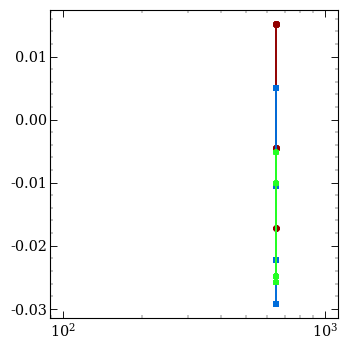

In [214]:
fig, ax = plt.subplots()
ax.plot(ptvals, get_ratio(
                                get_evaluator("Her", 'b')(etavals, ptvals),
                                get_evaluator("Py",  'b')(etavals, ptvals),
                                divideHerPy
                                 ) 
       )

ax.plot(ptvals, get_evaluator("Her", 'b')(etavals, ptvals)-1)
ax.plot(ptvals, get_evaluator("Py", 'b')(etavals, ptvals)-1)
ax.set_xscale('log')